# Project 2: Radio Data Analysis (Part 3 - Search for Unknown Signals)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from rich.pretty import Pretty
from sigpyproc.readers import FilReader
from projects.p2.part3.part3_funcs import *

In [94]:
read_data?

Signature: read_data(fil_file)
Docstring: <no docstring>
File:      ~/phys_641/projects/p2/part3/src_funcs.py
Type:      function

## Search for Unknown Signatures

We want to search for unknown signatures using the following framework:

1. Creating a basic model for this hypothetical signal.
2. Creating and applying a search method to find this signal in the radio data
provided.
3. Characterizing the detection limits of your search applied to the data.


## Preliminary Data and Model Exploration

Making use of my data set, I'm going to take a look at it and see what sort of signal I can make out. Then, I'll see if I can make a model of the data and potentially use the blank sky calibration to compute a transfer function and convert things to Jy. Let's see how this goes...

In [95]:
unknown_data_Fil = FilReader('./data_261084068.fil')
Pretty(unknown_data_Fil.header)

Header(
    filename='./data_261084068.fil',
    data_type='filterbank',
    nchans=1024,
    foff=-0.390625,
    fch1=800.0,
    nbits=32,
    tsamp=0.00032768,
    tstart=60638.34381999473,
    nsamples=30517,
    nifs=1,
    coord=<SkyCoord (ICRS): (ra, dec) in deg
    (0., 0.)>,
    azimuth=<Angle 0. deg>,
    zenith=<Angle 0. deg>,
    telescope='CHIME',
    backend='CHIME',
    source='Fake',
    frame='topocentric',
    ibeam=1,
    nbeams=1,
    dm=0.0,
    period=0,
    accel=0,
    signed=0,
    rawdatafile='test.dat',
    stream_info=StreamInfo(
        entries=[
            FileInfo(
                filename='./data_261084068.fil',
                hdrlen=414,
                datalen=124997632,
                nsamples=30517,
                tstart=60638.34381999473,
                tsamp=0.00032768
            )
        ]
    )
)

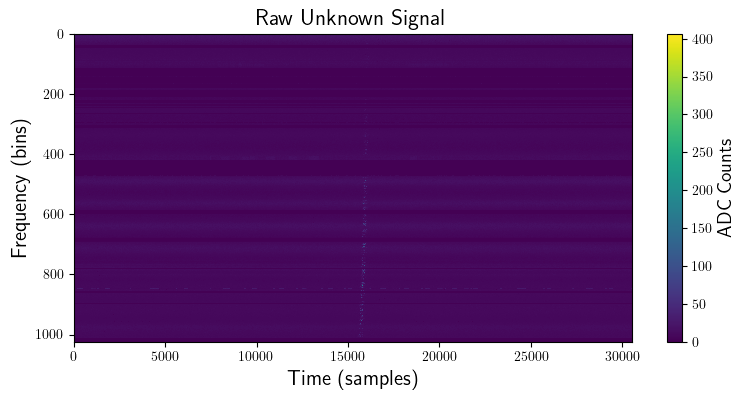

In [96]:
unknown_data = unknown_data_Fil.read_block(0,
                                           unknown_data_Fil.header.nsamples,
                                           unknown_data_Fil.header.fch1,
                                           unknown_data_Fil.header.nchans
                                           )
unknown_data_array = unknown_data.data

#make a quick waterfall plot of the pulsar data to see what we're working with
plot_imshow_transients(unknown_data_array, 
                       'Raw Unknown Signal',
                       'Time (samples)',
                       'Frequency (bins)',
                       'ADC Counts',
                       [(None),(None)],
                       (None),
                       (None),
                       (None), #should presented as a list ie. [..,.., etc..]
                       (9, 4),
                       16,
                       False)

#### Clean RFI

In [97]:
_, chan_mask = unknown_data_Fil.clean_rfi(method='mad', threshold=3)
unknown_data_Fil_masked = FilReader('data_261084068_masked.fil')

/home/mike/anaconda3/envs/641_projects_py12/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

In [98]:
unknown_data_Fil_masked.compute_stats()

In [99]:
unknown_data_masked = unknown_data_Fil_masked.read_block(0,
                                                         unknown_data_Fil_masked.header.nsamples,
                                                         unknown_data_Fil_masked.header.fch1,
                                                         unknown_data_Fil_masked.header.nchans,
                                                         )
unknown_data_masked_array = unknown_data_masked.data

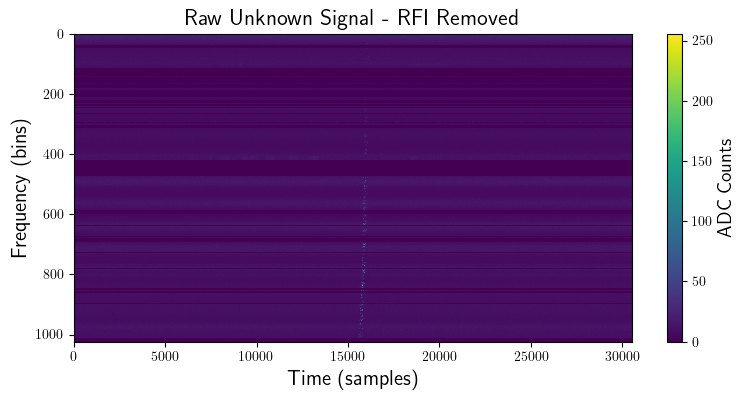

In [100]:
plot_imshow_transients(unknown_data_masked_array, 
                       'Raw Unknown Signal - RFI Removed',
                       'Time (samples)',
                       'Frequency (bins)',
                       'ADC Counts',
                       [None, None],
                       (None),
                       (None),
                       (None), #should presented as a list ie. [..,.., etc..]
                       (9, 4),
                       16,
                       False)

#### Normalize eand Downsaamle - Change extent to bring out obvious pulse

In [101]:
norm_unknown_Fil = unknown_data_masked.normalise()

Plot again..

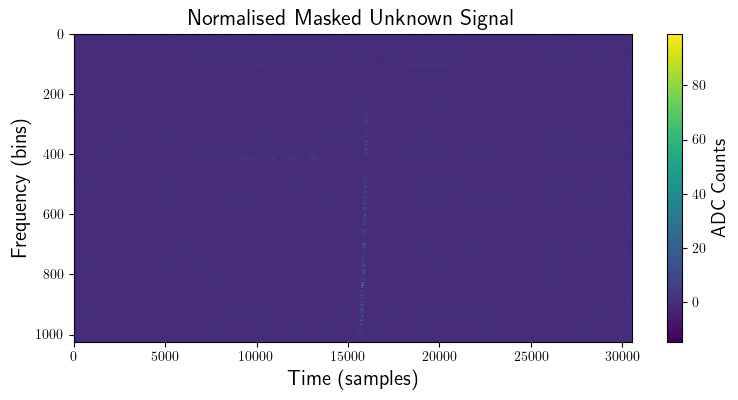

In [102]:
plot_imshow_transients(norm_unknown_Fil.data, 
                       'Normalised Masked Unknown Signal',
                       'Time (samples)',
                       'Frequency (bins)',
                       'ADC Counts',
                       [None, None], #vmin, vmax
                       (None), #xlim
                       (None), #ylim
                       (None), #extent should presented as a list ie. [..,.., etc..]
                       (9, 4),
                       16,
                       False)

In [103]:
print(np.sum(norm_unknown_Fil.data))

55.026184


#### Downsampling (&normalizing again)

In [104]:
unknown_data_Fil_masked.downsample(tfactor=32)

'data_261084068_masked_f1_t32.fil'

In [105]:
unknown_data_Fil_masked_32 = FilReader('data_261084068_masked_f1_t32.fil')

unknown_data_masked_32 = unknown_data_Fil_masked_32.read_block(0,
                                                               unknown_data_Fil_masked_32.header.nsamples,
                                                               unknown_data_Fil_masked_32.header.fch1,
                                                               unknown_data_Fil_masked_32.header.nchans
                                                               )
norm_data_masked_32 = unknown_data_masked_32.normalise()
# norm_data_masked_32 = unknown_data_masked_32

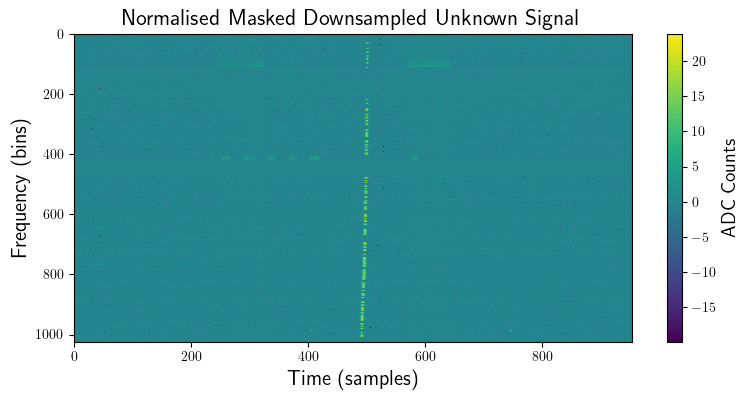

In [106]:
plot_imshow_transients(norm_data_masked_32.data, 
                       'Normalised Masked Downsampled Unknown Signal',
                       'Time (samples)',
                       'Frequency (bins)',
                       'ADC Counts',
                       [None, None], #vmin, vmax
                       (None), #xlim
                       (None), #ylim
                       (None), #extent ie. [..,.., etc..]
                       (9, 4),
                       16,
                       False)

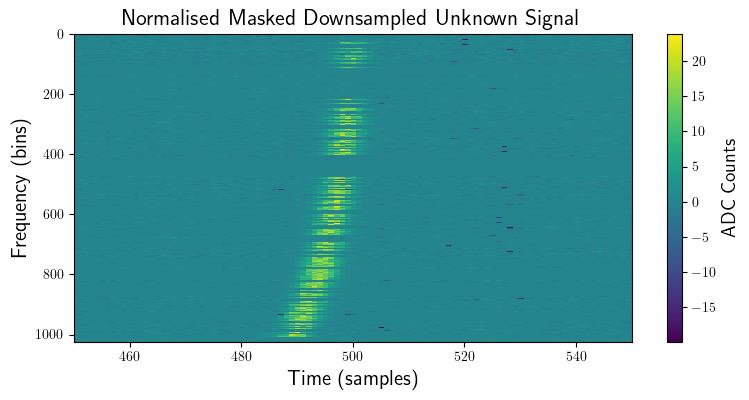

In [107]:
plot_imshow_transients(norm_data_masked_32.data, 
                       'Normalised Masked Downsampled Unknown Signal',
                       'Time (samples)',
                       'Frequency (bins)',
                       'ADC Counts',
                       [None, None], #vmin, vmax
                       (450, 550), #xlim
                       (None), #ylim
                       (None), #extent ie. [..,.., etc..]
                       (9, 4),
                       16,
                       False)

#### De-dispersing

Normally, could just fold the data using the sigpyproc functions, but we need to likely write a custom dedispersion function to be able to perform this during the search over various paramters.

Actually, it seems this is fully possible with just using a -ve DM value in the original dedisperse function, as shown below.

In [67]:
norm_data_masked_32_ded = norm_data_masked_32.dedisperse(-5.5)

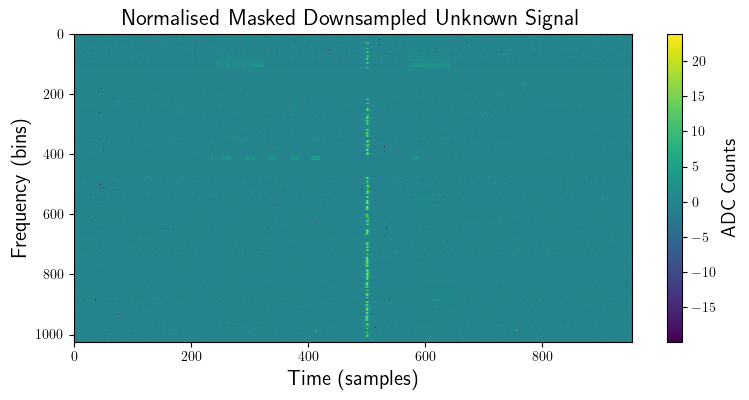

In [68]:
plot_imshow_transients(norm_data_masked_32_ded.data, 
                       'Normalised Masked Downsampled Unknown Signal',
                       'Time (samples)',
                       'Frequency (bins)',
                       'ADC Counts',
                       [None, None], #vmin, vmax
                       (None), #xlim
                       (None), #ylim
                       (None), #extent ie. [..,.., etc..]
                       (9, 4),
                       16,
                       False)

Up until now, mostly have done the part of ensuring I can test a model that I come up with. Meaning of having a model:

- seeing if the signal is
    - broadband?
    - repeating?
    - luminosity or spectral index?
    - certain DM $\rightarrow$ likely the most important since non-astrophysical

Should now be able to search over a range of values and determine whether I have actually found a signal of interest.

Could be useful to consider a DM < 0 cut and also a certain S/N threshold.

### Check over list of DMs and Pulse widths

In terms of the model, and assumption of broadband signal and non repeating is perhaps a likely scenario.


Want to do something like a convolution to try and pick out the pulse signal as if it weren't obvious to find what it looks like by just examinign the waterfall plot.

Eq.

Text(0.5, 0, 'Normalized frequency [cycles per sample]')

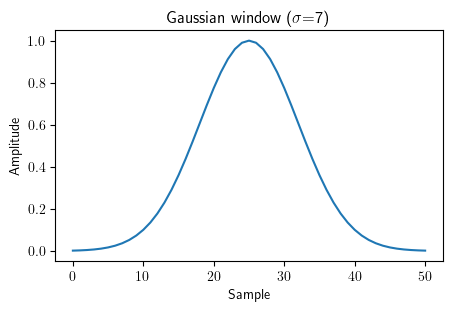

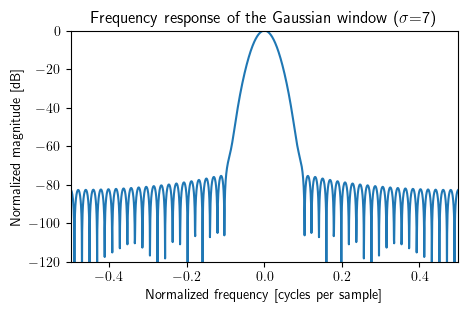

In [110]:
#convolution practice...

import numpy as np
from scipy import signal
from scipy.fft import fft, fftshift
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (5,3)
window = signal.windows.gaussian(51, std=7)
plt.plot(window)
plt.title(r"Gaussian window ($\sigma$=7)")
plt.ylabel("Amplitude")
plt.xlabel("Sample")

plt.figure()
A = fft(window, 2048) / (len(window)/2.0)
freq = np.linspace(-0.5, 0.5, len(A))
response = 20 * np.log10(np.abs(fftshift(A / abs(A).max())))
plt.plot(freq, response)
plt.axis([-0.5, 0.5, -120, 0])
plt.title(r"Frequency response of the Gaussian window ($\sigma$=7)")
plt.ylabel("Normalized magnitude [dB]")
plt.xlabel("Normalized frequency [cycles per sample]")


/tmp/ipykernel_209584/520944738.py:20: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


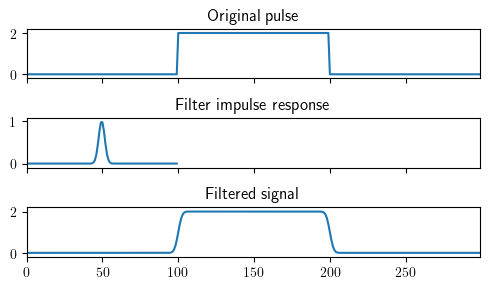

In [111]:
import numpy as np
from scipy import signal
sig = np.repeat([0., 2., 0.], 100)
# win = signal.windows.hann(50)
win = signal.windows.gaussian(100, 2)
filtered = signal.convolve(sig, win, mode='same') / sum(win)

import matplotlib.pyplot as plt
fig, (ax_orig, ax_win, ax_filt) = plt.subplots(3, 1, sharex=True)
ax_orig.plot(sig)
ax_orig.set_title('Original pulse')
ax_orig.margins(0, 0.1)
ax_win.plot(win)
ax_win.set_title('Filter impulse response')
ax_win.margins(0, 0.1)
ax_filt.plot(filtered)
ax_filt.set_title('Filtered signal')
ax_filt.margins(0, 0.1)
fig.tight_layout()
fig.show()

In [112]:
DM_list = np.linspace(-10, 10, 10)
DM_widths = np.linspace(0, 10, 10)   #pretty sure this the std of the gaussian 


#clean rfi

#downsample

#normalize

#create unknown signal list []
#create blank sky list []

#NOTE WE ARE GOING TO DO THE FOLLOWING FOR BOTH THE BLANK SKY 
# AND THE PULSE SIGNAL DATA
#SNR_array = np.zeros((len(DM_list, DM_width)))
# for DM in DM_list:
    
    #dedisperse by the amount for DM

    #Sum over frequency bins -> return the 1D array

#   for width in DM_widths:
    
        #define gaussian pulse using the width as the std

        #convolve the 1D array with Gaussian pulse -> return convolved time series

        #compute (for each)
        #max()

        #let SNR = compute convolved pulse / convolved blank sky

        #if SNR > 5:
            #threshold_array.append(SNR)
#            SNR_array[DM, width] = SNR
        


#then use the std of the blank sky set and calcualte:
#unknown sigal / blank sky 
#to find the location of optimal S/N

Try the above with just one DM and width to get a sense for picking out the statistics

In [69]:
#do for just unknown signal first, I already have done the rfi removal, downsample, and normalize above

#sum dedispersed pulse data
t_series = np.sum(norm_data_masked_32_ded.data, axis = 0)

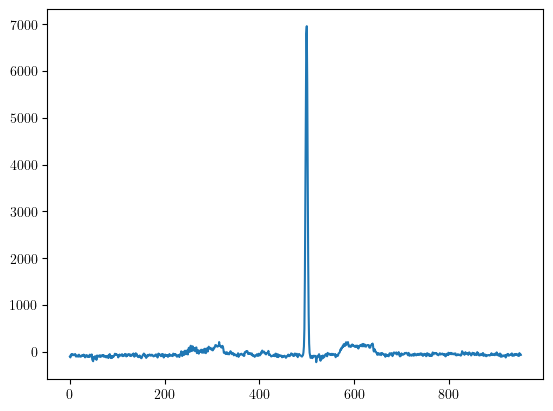

In [70]:
plt.plot(t_series)

In [139]:
window = signal.windows.gaussian(400, 1)
# window = window / np.sum(window)
tt_series = signal.convolve(t_series, window)

8.594141414141413


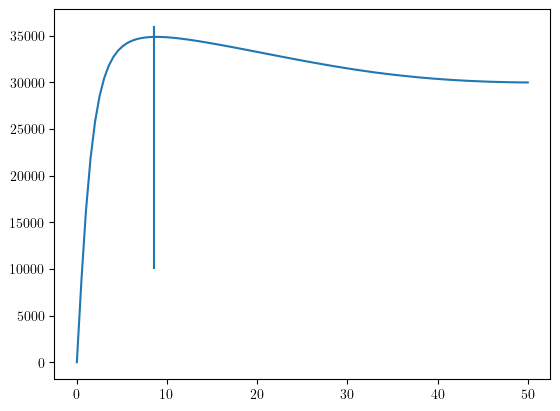

In [72]:
ws = np.linspace(0.01, 50, 100)

ts = []
for w in ws:
    windw = signal.windows.gaussian(400, w)
    # windw = windw / np.sum(windw)
    ttt_series = signal.convolve(t_series, windw)
    ts.append(np.max(ttt_series))

max_ts = np.argmax(ts)
plt.plot(ws, ts)
plt.vlines(ws[max_ts], ymin=10000, ymax=36000)
print(ws[max_ts])

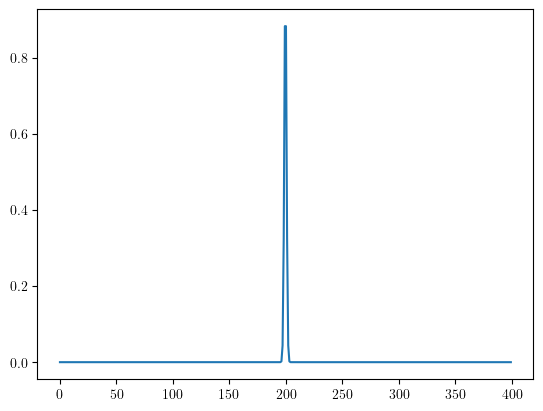

In [140]:
plt.plot(window)

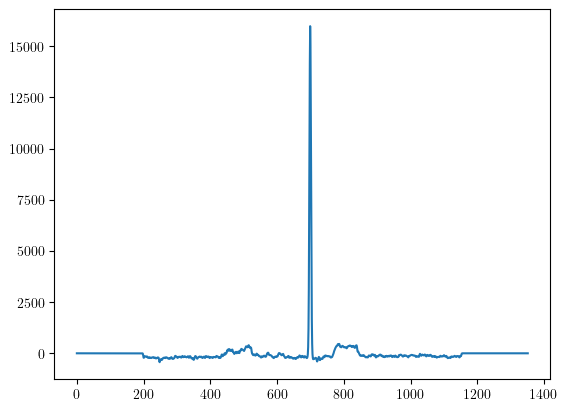

In [141]:
plt.plot(tt_series)

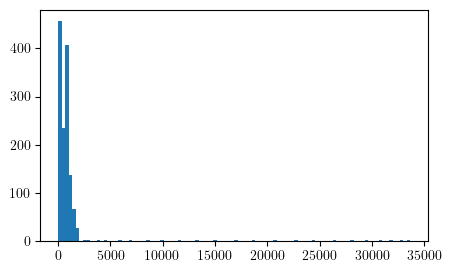

In [119]:
fig = plt.hist(np.abs(tt_series), bins=100)

In [120]:
blank_sky_masked_Fil_32 = FilReader('../data/blank_sky_masked_f1_t32.fil')


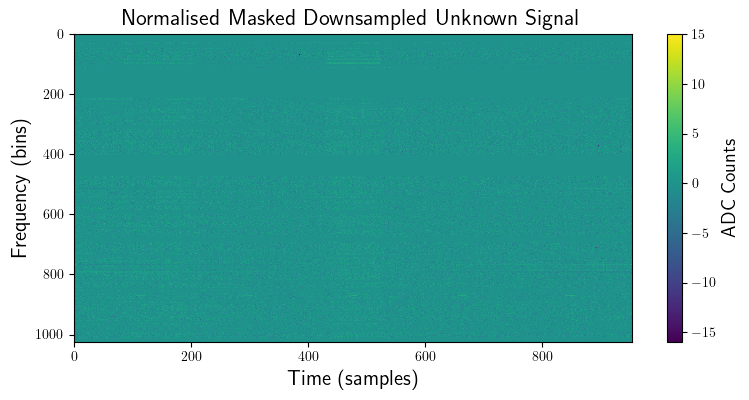

In [121]:
blank_sky_masked_32 = read_data(blank_sky_masked_Fil_32)
norm_blank_sky_masked_32 = blank_sky_masked_32.normalise()
norm_blank_sky_masked_32_ded = norm_blank_sky_masked_32.dedisperse(-5)

plot_imshow_transients(norm_blank_sky_masked_32_ded.data, 
                       'Normalised Masked Downsampled Unknown Signal',
                       'Time (samples)',
                       'Frequency (bins)',
                       'ADC Counts',
                       [None, None], #vmin, vmax
                       (None), #xlim
                       (None), #ylim
                       (None), #extent ie. [..,.., etc..]
                       (9, 4),
                       16,
                       False)

In [122]:
bs = np.sum(norm_blank_sky_masked_32_ded.data, axis = 0)

85.82075
269.85013


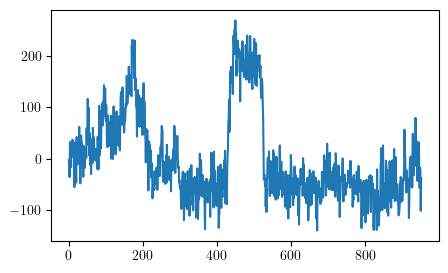

In [123]:
plt.plot(bs)
print(np.std(bs))
print(np.max(bs))

In [124]:
print(np.max(tt_series),
      np.mean(tt_series))

33678.104975825205 0.0012560637932378914


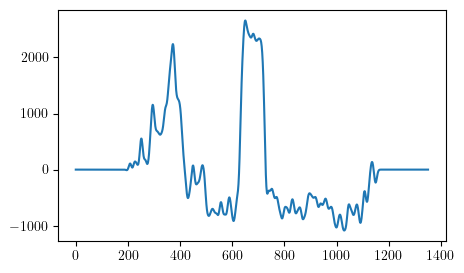

In [125]:
bs_t_series = signal.convolve(bs, window)
# bs_t_series = np.abs(bs_t_series)
plt.plot(bs_t_series)

In [126]:
noise = np.std((bs_t_series))
max_noise = np.max(bs_t_series)
# max_noise = np.max(bs)
print(max_noise)
print(noise)

2659.3247024740785
833.1691274718394


In [127]:
# snr_b2 = bs_t_series/np.std(bs)
# plt.plot(snr_b2)

In [128]:
# print(np.std(tt_series))
# snr = np.max(tt_series)/np.std(bs_t_series)
snr_t = np.max(tt_series)/max_noise
snr = np.max(tt_series)/noise
# plt.plot(snr)
print(snr_t)
print(snr)

12.664156785552771
40.4216909452919


In [129]:
bs_snr = bs_t_series/max_noise

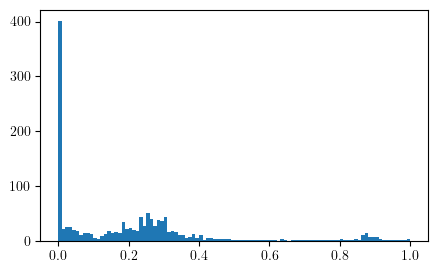

In [130]:
fig = plt.hist(np.abs(bs_snr), bins = 100)

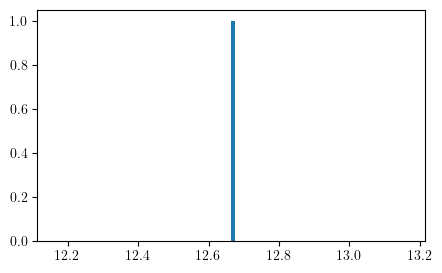

In [131]:
# plt.plot(snr_t)
fig = plt.hist(np.abs(snr_t), bins=100)

In [132]:
print(np.max(snr), 
      np.max(snr_b2))

NameError: name 'snr_b2' is not defined

In [ ]:
a = (3,2)
print(a[0])

In [ ]:
# test_window = signal.windows.gaussian(100, 5)
# peaks = np.array(np.argmax(test_window))
# pw = signal.peak_widths(test_window, peaks)

Using the DM_width_search function... 

In [ ]:
from projects.p2.part3.part3_funcs import *
from sigpyproc.readers import FilReader

In [ ]:
def gaussian_kernel(mu, sig, xvals):
    return np.exp(-(1/2)*())

In [ ]:
def DM_width_search(signal_data, blank_sky, DM_range, width_range, cand_threshold, normalize=True):
    """
    function to search over DMs and widths and return 
    the SNR 2d array based on candidates passing the selection
    criteria. Allow option to return the SNR histogram for each
    successful candidate and the blank sky SNR histogram for the
    same DM and width params.

    Any time you need to load in a new file (eg. from downsampling
    or rfi-flagged) this should be done before passing the arrays
    to this function. The only preprocessing that should happen
    then in here is the option to normalize some amount before
    dedispersing in the DM search.
    """

    #Again, assume that things have been downsampled and flagged for rfi already

    # DM_min, DM_max = DM_range[0], DM_range[1]
    # width_min, width_max = width_range[0], width_range[1]

    DM_width_search = np.zeros((DM_range.shape[0], width_range.shape[0]))
    print(DM_width_search.shape)

    if normalize:
        signal_data = signal_data.normalise()
        blank_sky = blank_sky.normalise()

    for i, DM in enumerate(DM_range):
        # print("Hello")

        signal_dd = signal_data.dedisperse(DM)
        blank_sky_dd = blank_sky.dedisperse(DM)

        signal_dd_tseries = np.sum(signal_dd.data, axis=0)
        blank_sky_dd_tseries = np.sum(blank_sky_dd.data, axis=0)

        for j, width in enumerate(width_range):    
            gauss_kernel = signal.windows.gaussian(400, width)

            signal_convolution = signal.convolve(signal_dd_tseries, gauss_kernel)
            blank_sky_convolution = signal.convolve(blank_sky_dd_tseries, gauss_kernel)

            max_convolved_signal = np.max(signal_convolution)
            max_convolved_noise = np.max(blank_sky_convolution)
            
            
            # print(max_convolved_signal)
            # print()
            # print(max_convolved_noise)

            blank_sky_noise = np.std(blank_sky_convolution)/np.sqrt(width)
            # blank_sky_noise = np.max(blank_sky_convolution)
            # blank_sky_noise = np.std(blank_sky_dd_tseries)

            # pulse_start = np.argmax(max_convolved_signal) - width//2
            candidate_thresh = (max_convolved_signal/max_convolved_noise)
            # print(candidate_thresh)

            if candidate_thresh > cand_threshold:
                SNR = max_convolved_signal / blank_sky_noise
                # SNR = max_convolved_signal

                DM_width_search[i, j] = SNR
                # print(SNR)

    #search DM and width to find max values
    max_DIM_width_inds = np.argmax(DM_width_search)
    max_DM_ind, max_width_ind = np.unravel_index(max_DIM_width_inds, DM_width_search.shape)
    max_DM, max_width = DM_range[max_DM_ind], width_range[max_width_ind]

    return DM_width_search, max_DM, max_width

In [243]:
def plot_SNR_hist(signal_data, blank_sky, DM, width):
    """
    function to plot the SNR histogram given a particular
    DM and width. Assume the data is handed to the 
    function already dedispersed and rfi-flagged.
    """
    signal_data = signal_data.normalise()
    blank_sky = blank_sky.normalise()
    
    signal_dd = signal_data.dedisperse(DM)
    blank_sky_dd = blank_sky.dedisperse(DM)

    signal_dd_tseries = np.sum(signal_dd.data, axis=0)
    blank_sky_dd_tseries = np.sum(blank_sky_dd.data, axis=0)

    gauss_kernel = signal.windows.gaussian(400, width)

    signal_convolution = signal.convolve(signal_dd_tseries, gauss_kernel)
    blank_sky_convolution = signal.convolve(blank_sky_dd_tseries, gauss_kernel)

    SNR = signal_convolution / np.std(blank_sky_convolution) / np.sqrt(width)

    fig = plt.hist(SNR, bins = 100, density = False)
    # plt.xlim(0.1, 50)
    # plt.ylim(0, 10)

    plt.figure()
    plt.plot(signal_dd_tseries)
    plt.figure()
    plt.plot(signal_convolution)

In [10]:
#signal data loading
unknown_data_Fil_masked_32 = FilReader('data_261084068_masked_f1_t32.fil')
unknown_data_masked_32 = unknown_data_Fil_masked_32.read_block(0,
                                                               unknown_data_Fil_masked_32.header.nsamples,
                                                               unknown_data_Fil_masked_32.header.fch1,
                                                               unknown_data_Fil_masked_32.header.nchans
                                                               )
norm_data_masked_32 = unknown_data_masked_32.normalise()

In [11]:
#blank sky data loading
blank_sky_masked_Fil_32 = FilReader('../data/blank_sky_masked_f1_t32.fil')
blank_sky_masked_32 = read_data(blank_sky_masked_Fil_32)
norm_blank_sky_masked_32 = blank_sky_masked_32.normalise()

In [183]:
#assuming all rfi-excisiona and dedispersing has been completed
DM_range = np.linspace(-30, -1, 30)
width_range = np.linspace(0.04, 20, 30)
cand_threshold = 5

In [184]:
# print(np.zeros((DM_range.shape[0], width_range.shape[0])))

In [187]:

DM_widths, max_DM, max_width = DM_width_search(norm_data_masked_32,
                            norm_blank_sky_masked_32,
                            DM_range,
                            width_range,
                            cand_threshold,
                            False
                            )


(30, 30)


In [188]:
print(max_DM, max_width)

-7.0 2.1048275862068966


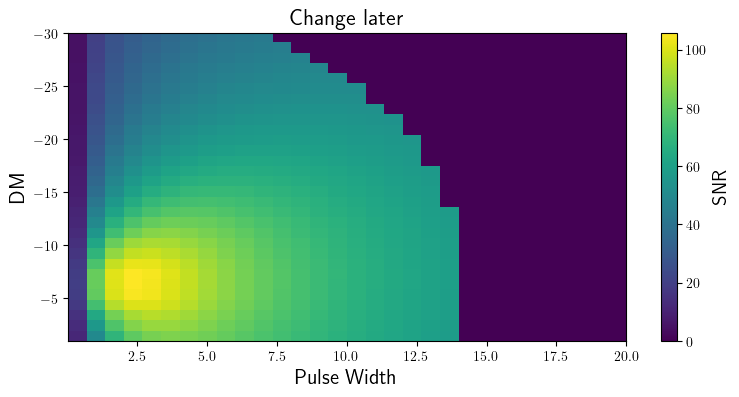

In [190]:
plot_imshow_transients(DM_widths, 
                       'Change later',
                       'Pulse Width',
                       'DM',
                       'SNR',
                       [None, None], #vmin, vmax
                       (None), #xlim
                       (None), #ylim
                       [width_range.min(), width_range.max(), DM_range.max(), DM_range.min()], #extent ie. [..,.., etc..]
                       (9, 4),
                       16,
                       False)

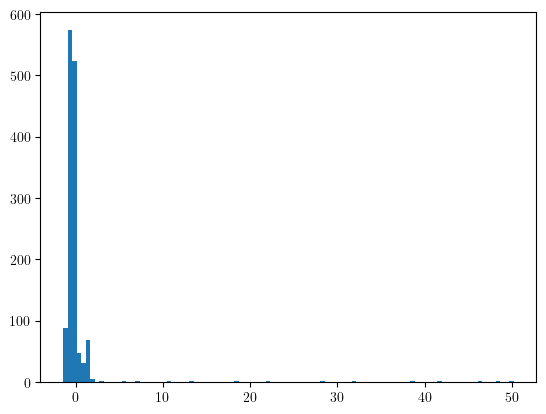

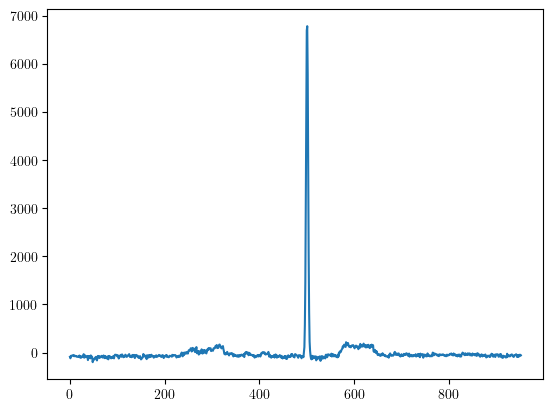

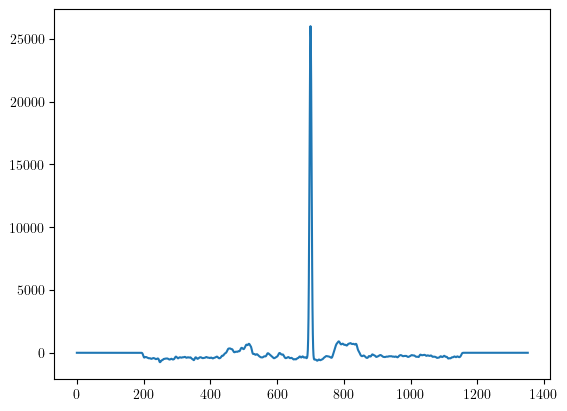

In [246]:
plot_SNR_hist(norm_data_masked_32, norm_blank_sky_masked_32, max_DM, max_width)

In [181]:
max_2d_ind = (np.argmax(DM_widths))
max_DM, max_width = np.unravel_index(max_2d_ind, DM_widths.shape)

print(max_DM, max_width)

242 32


In [182]:
print(width_range[9])

0.6408026755852844


In [160]:
print(DM_widths[max_DM,:])

[ 13.91430921  93.82889128 106.46284981 103.25754256  96.70175189
  90.15352224  84.34954866  79.35049274  75.0577834   71.35292785
  68.13155894  65.3085411   62.81592727  60.59969822  58.61677496
  56.83292064  55.22453245  53.76231603  52.42804355  51.20663881
  50.08556373  49.0543408   48.10417304  47.22763497  46.41841792
  45.67111908  44.98199871  44.3481517   43.76407854  43.22652809
  42.73256321  42.27950474  41.86488827  41.48643075  41.14200458
  40.82961743  40.55146864  40.30381696  40.08268413  39.88648995
  39.71520459  39.57128874  39.44769784  39.34315091  39.26262641
  39.19918917  39.15150189  39.1241591   39.10954851  39.11049294]
